In [1]:
# Annie Polish
# Summer 2019

# README: How to prepare data for this script
# Open DatCon (from datfile.net)
# Set Parsing Options to Engineered, then DatDefined
# Set the Sample Rate to 100Hz
# Set the output location to ./CSV_files (relative to this script)
# GO!
# In this file, set BASENAME to the name of your file
# Run this script. The plot will be saved to ./plots

import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import math
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopy.distance

plt.rcParams.update({'font.size': 16})

########################
# CONSTANT DEFINITIONS #
########################
BASENAME = "FLY126" # filename to run on
BORDER = 0.00025 # sets the border around the dataset, in degrees of lat/long
PLOT_BG = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
COL_LIST = ["IMU_ATTI(0):pitch", "IMU_ATTI(0):yaw360", "IMU_ATTI(0):roll",
            "IMU_ATTI(1):pitch", "IMU_ATTI(1):yaw360", "IMU_ATTI(1):roll",
            "IMU_ATTI(2):pitch", "IMU_ATTI(2):yaw360", "IMU_ATTI(2):roll",
            "rtkdata:pitch", "rtkdata:YAW",
            "GPS:dateTimeStamp", "offsetTime"]

Change "BASENAME" to set which file you run on

All CSVs should be in the same directory as this notebook

Plots land in ./plots

In [2]:
# returns the statistics of the coordinates in a given time interval
def stationaryStats(df, startTime, endTime):
    print('hello stationary stats')
    # slice off part of the dataframe
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    lat_arr  = df_slice["Lat"].values
    lon_arr  = df_slice["Lon"].values
    hmsl_arr = df_slice["hmsl"].values
    # find max and min of each coordinate, and the distance that represents
    max_lat  = np.max(lat_arr)
    min_lat  = np.min(lat_arr)
    max_lon  = np.max(lon_arr)
    min_lon  = np.min(lon_arr)
    lat_dist = geopy.distance.distance((min_lat, lon_arr[0]), (max_lat, lon_arr[0])).m
    lon_dist = geopy.distance.distance((lat_arr[0], min_lon), (lat_arr[0], max_lon)).m
    print("Latitude spread: "+str(lat_dist))
    print("Longitude spread: "+str(lon_dist))
    print("Diagonal distance: "+str(math.sqrt(lat_dist**2 + lon_dist**2)))
    print("Double check: "+str(geopy.distance.distance((min_lat, min_lon),(max_lat, max_lon)).m))
    # find the standard deviation of each coordinate
    lat_dev  = np.std(lat_arr)
    lon_dev  = np.std(lon_arr)
    hmsl_dev = np.std(hmsl_arr)
    # convert stddev in degrees to stddev in meters
    startCoords = (lat_arr[0], lon_arr[0])
    latCoords = (lat_arr[0]+lat_dev, lon_arr[0])
    lonCoords = (lat_arr[0], lon_arr[0]+lon_dev)
    endCoords = (lat_arr[0]+lat_dev, lon_arr[0]+lon_dev)
    lat_dist = geopy.distance.distance(startCoords, latCoords).m
    lon_dist = geopy.distance.distance(startCoords, lonCoords).m
    xy_dist = geopy.distance.distance(startCoords, endCoords).m
    # print and return
    print("Latitude standard deviation: "+str(lat_dist)+" meters")
    print("Longitude standard deviation: "+str(lon_dist)+" meters")
    print("Height standard deviation: "+str(hmsl_dev)+" meters")
    print("Diagonal lat-lon stddev: "+str(xy_dist)+" meters")
    return (lat_dist, lon_dist, hmsl_dev, xy_dist)

In [3]:
FLY = pd.read_csv("./CSV_files/"+BASENAME+".csv", sep=",", header=0, usecols=COL_LIST)#, nrows=15000)

In [14]:
# rename columns, do some initial processing
rtk_p = pd.DataFrame()
rtk_p["sec_elapsed"] = FLY["offsetTime"]
rtk_p["pitch0"] = FLY["IMU_ATTI(0):pitch"]
rtk_p["pitch1"] = FLY["IMU_ATTI(1):pitch"]
rtk_p["pitch2"] = FLY["IMU_ATTI(2):pitch"]
rtk_p["yaw0"]   = FLY["IMU_ATTI(0):yaw360"]
rtk_p["yaw1"]   = FLY["IMU_ATTI(1):yaw360"]
rtk_p["yaw2"]   = FLY["IMU_ATTI(2):yaw360"]
rtk_p["roll0"]  = FLY["IMU_ATTI(0):roll"]
rtk_p["roll1"]  = FLY["IMU_ATTI(1):roll"]
rtk_p["roll2"]  = FLY["IMU_ATTI(2):roll"]
rtk_p["pitch_rtk"] = FLY["rtkdata:pitch"]
rtk_p["yaw_rtk"]= FLY["rtkdata:YAW"]
rtk_p["pitch_av"] = (rtk_p["pitch0"] + rtk_p["pitch1"] + rtk_p["pitch2"])/3.
rtk_p["pitch_med"]= rtk_p[["pitch0", "pitch1", "pitch2"]].median(axis=1)
rtk_p["yaw_av"] = (rtk_p["yaw0"] + rtk_p["yaw1"] + rtk_p["yaw2"])/3.
rtk_p["yaw_med"]= rtk_p[["yaw0", "yaw1", "yaw2"]].median(axis=1)
rtk_p["yaw_rtk_rot"] = np.mod(np.add(rtk_p["yaw_rtk"].values, 90.), 360)
rtk_p = rtk_p.where(rtk_p != 0.)
rtk_p.dropna(inplace=True)
# arbitrarily trim the first and last ?? values
if(BASENAME == "FLY097"):
    rtk_p = rtk_p.iloc[11700:]
    rtk_p = rtk_p.iloc[:-1000]
else:
    rtk_p = rtk_p.iloc[100:]
    rtk_p = rtk_p.iloc[:-10]

In [5]:
# retrieve the date
print(FLY["GPS:dateTimeStamp"].values[100])
date = FLY["GPS:dateTimeStamp"].values[100]
date = date[:10]

2019-06-14T19:58:10Z


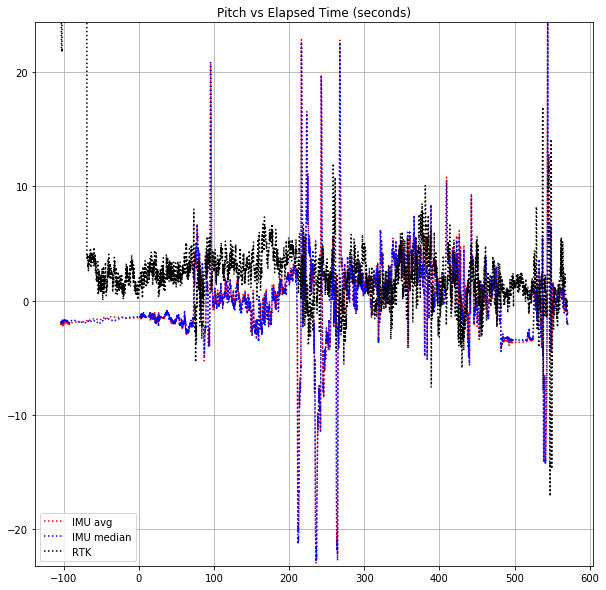

In [6]:
fig = plt.figure(figsize=(10,10))
plt.title("Pitch vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["pitch0"].values), max(rtk_p["pitch0"].values))
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch0"].values, "c:", label="IMU 0")
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch1"].values, "y:", label="IMU 1")
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch2"].values, "m:", label="IMU 2")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch_av"].values, 'r:', label="IMU avg")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch_med"].values, 'b:', label="IMU median")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["pitch_rtk"].values, "k:", label="RTK")
plt.grid()
ax = plt.gca()
ax.legend()
plt.savefig("./plots/"+BASENAME+"_pitch.png")
plt.show()

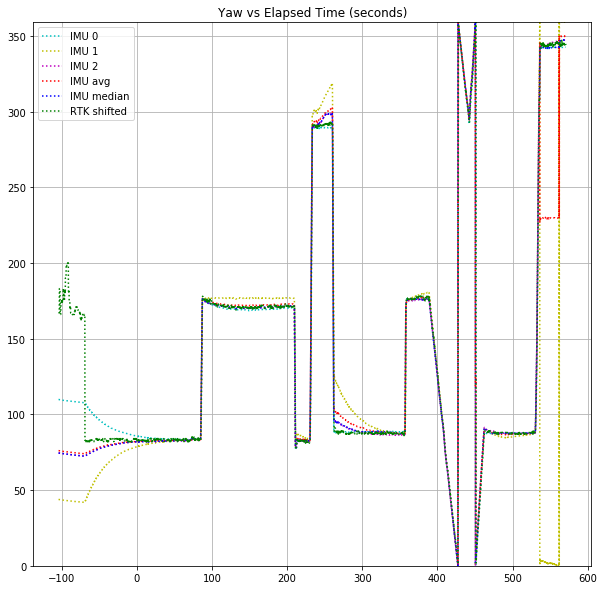

In [18]:
fig = plt.figure(figsize=(10,10))
plt.title("Yaw vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["yaw0"].values), max(rtk_p["yaw_rtk"].values))
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw0"].values, "c:", label="IMU 0")
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw1"].values, "y:", label="IMU 1")
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw2"].values, "m:", label="IMU 2")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw_av"].values, 'r:', label="IMU avg")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw_med"].values, 'b:', label="IMU median")
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw_rtk_rot"].values, 'g:', label="RTK shifted")
#plt.plot(rtk_p["sec_elapsed"].values, rtk_p["yaw_rtk"].values, "k:", label="RTK")
plt.grid()
ax = plt.gca()
ax.legend()
plt.savefig("./plots/"+BASENAME+"_yaw.png")
plt.show()

The yaw reading from the RTK is initially not lined up with the reading from the IMU, but it eventually aligns to 90 degrees off. Once this 90 degree offset is corrected, the RTK agrees with the IMU. The RTK also changes faster than the IMU. It's not clear which of these is more correct.

In [19]:
START_CUT = 100 
END_CUT = 200
df_slice = rtk_p[rtk_p["sec_elapsed"] > START_CUT]
df_slice = df_slice[df_slice["sec_elapsed"] < END_CUT]

av_offset = np.mean(np.mod(np.subtract(df_slice["yaw_med"].values, df_slice["yaw_rtk"].values),360))
print(av_offset)
#90

89.83207978722584
